# L’orbite du télescope spatial James Webb (simulations numériques en Python)



[Vidéo d'illustration](https://www.youtube.com/watch?v=QnqEcD02SWw)

## Mise en équation pour la simulation numérique

La position $\vec{r_J}$ et la vitesse $\vec{v_J}$ de JWST sont définies dans le référentiel tournant à la vitesse $\Omega_T$, dont l'origine est le point de Lagrange $L_2$.

Le point $S$ désigne le Soleil. Le point $T$ désigne le barycentre Terre-Lune. L'axe $X$ est dans la direction Soleil-Terre.
\begin{equation}
\vec{r_J}=\left(\begin{matrix}X\\Y\\Z\end{matrix}\right)\quad
\vec{v_J}=\left(\begin{matrix}V_X\\V_Y\\V_Z\end{matrix}\right)
\end{equation}
L'équation dynamique est la suivante ($\mu_S$ est le paramètre gravitationnel standard du Soleil, $\mu_T$ est celui du couple Terre-Lune) :
\begin{align}
\frac{d\vec{r_J}}{dt}&=\vec{v_J}\\
\frac{d\vec{v_J}}{dt}&=-\mu_S\frac{\vec{SL_2}+\vec{r_J}}{\left\lVert\vec{SL_2}+\vec{r_J}\right\lVert^3}-\mu_T\frac{\vec{TL_2}+\vec{r_J}}{\left\lVert\vec{TL_2}+\vec{r_J}\right\lVert^3}+\Omega_T^2\left(\begin{matrix}\left\lVert\vec{SL_2}\right\lVert+X\\Y\\0\end{matrix}\right)+2\Omega_T\left(\begin{matrix}V_Y\\-V_X\\0\end{matrix}\right)
\end{align}

## Code initial à exécuter avant les appels aux fonctions (contenu du fichier **jwst.py**)



In [ ]:
# -*- coding: utf-8 -*-
"""
jwst

Liste des fonctions :
--------------------
constantes()
traj_opt(X0=162000,V0=-0.305,Z=-470000,Papprox=180,Pas=1,Graph=True,Axe=True)
traj_lsq(params,Z,muS,muT,RT,OT,RL2,Papprox,Pas)
test_traj(Z=-470000,Xmin=-400000.0,YN=20000.0,
    Xi=np.arange(150000,200000,1000),VYi=-np.arange(0.3,0.4,0.005),Papprox=180,Pas=1)
traj(y0=[162000,0,-470000,0,-0.305,0],Duree=180,Pas=1,Graph=True,Axe=True)
recherche_l2(muS,muT,RT,OT)
acceleration(x,muS,muT,RT,OT)
equ_dyn_jwst(y,muS,muT,RT,OT,RL2)
energie_totale(y,muS,muT,RT,OT,RL2)
trace_energie(y,muS,muT,RT,OT,RL2,temps)
trace_vitesse(VX,VY,VZ,temps)
trace_position(X,Y,Z,RT,RL2,temps,Axe)
rk4(f,t,y0)
rk8(f,t,y0)
--------------------
@author KM (10/08/2023)
"""

import numpy as np
from numpy.linalg import norm
from scipy.optimize import fsolve
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def constantes():
    muS=132712440041.279419
    muT=398600.435507+4902.800118
    RT=149.6e6
    OT=(2*np.pi)/(365.256*24*3600)
    return muS,muT,RT,OT

def traj_opt(X0=162000,V0=-0.305,Z=-470000,Papprox=180,Pas=1,Graph=True,Axe=True):
    muS,muT,RT,OT=constantes()
    RL2=RT+recherche_l2(muS,muT,RT,OT)
    params0=[X0,V0]
    y0_init=[params0[0],0,Z,0,params0[1],0]
    res=least_squares(lambda params : traj_lsq(params,Z,muS,muT,RT,OT,RL2,Papprox,Pas),params0)
    y0=[res.x[0],0,Z,0,res.x[1],0]
    t_cal=24*3600*np.arange(0,0.75*Papprox+Pas,Pas)
    _,y=rk4(lambda t,y : equ_dyn_jwst(y,muS,muT,RT,OT,RL2),t_cal,y0)
    f=interp1d(t_cal,y,axis=0,kind='cubic')
    Periode=2*fsolve(lambda t : f(t)[:,1],3600*24*0.5*Papprox)[0]/(3600*24)
    if Graph==True:
        t_cal=24*3600*np.arange(0,Periode+Pas,Pas)
        _,y=rk4(lambda t,y : equ_dyn_jwst(y,muS,muT,RT,OT,RL2),t_cal,y0)
        X=y[:,0];Y=y[:,1];Z=y[:,2]
        VX=y[:,3];VY=y[:,4];VZ=y[:,5]
        trace_position(X,Y,Z,RT,RL2,t_cal/(3600*24),Axe)
        trace_vitesse(VX,VY,VZ,t_cal/(3600*24))
        trace_energie(y,muS,muT,RT,OT,RL2,t_cal/(3600*24))
        plt.show()
    return y0,y0_init,Periode

def traj_lsq(params,Z,muS,muT,RT,OT,RL2,Papprox,Pas):
    y0=[params[0],0,Z,0,params[1],0]
    t_cal=24*3600*np.arange(0,0.75*Papprox+Pas,Pas)
    _,y=rk4(lambda t,y : equ_dyn_jwst(y,muS,muT,RT,OT,RL2),t_cal,y0)
    f=interp1d(t_cal,y,axis=0,kind='cubic')
    t_y0=fsolve(lambda t : f(t)[:,1],3600*24*0.5*Papprox)[0]
    return [f(t_y0)[3],f(t_y0)[5]]

def test_traj(Z=-470000,Xmin=-400000.0,YN=20000.0,
    Xi=np.arange(150000,200000,1000),VYi=-np.arange(0.3,0.4,0.005),Papprox=180,Pas=1):
    Xf=[];Yf=[];info=[]
    for n in range(0,len(Xi)):
        for k in range(0,len(VYi)):
            X,Y=traj(y0=[Xi[n],0,Z,0,VYi[k],0],Duree=0.5*Papprox,Pas=Pas,Graph=False,Axe=False)
            if (X<Xi[n]) & (X>Xmin) & (np.absolute(Y)<YN):
                print(f'X0={Xi[n]:.0f}, V0={VYi[k]:.3f},Xfinal={X:.3f},Yfinal={Y:.3f}')
                info.append(f'X0={Xi[n]:.0f}, V0={VYi[k]:.3f}')
                Xf.append(X/1000);Yf.append(Y/1000)
    plt.figure
    plt.scatter(Xf,Yf)
    for n in range(len(Xf)):
        plt.text(Xf[n],Yf[n],info[n],ha='center',va='bottom',color='r',
        fontsize=8,weight='bold',alpha=0.8)
    plt.grid('on')
    plt.title(f'Points d\'arrivée après {0.5*Papprox:.3f} jours')
    plt.xlabel('Xfinal (x 1000 km)'),plt.ylabel('Yfinal (x 1000 km)')
    plt.show()

def traj(y0=[162000,0,-470000,0,-0.305,0],Duree=180,Pas=1,Graph=True,Axe=True):
    muS,muT,RT,OT=constantes()
    RL2=RT+recherche_l2(muS,muT,RT,OT)
    t_cal=24*3600*np.arange(0,Duree+Pas,Pas)
    _,y=rk4(lambda t,y : equ_dyn_jwst(y,muS,muT,RT,OT,RL2),t_cal,y0)
    X=y[:,0];Y=y[:,1];Z=y[:,2]
    VX=y[:,3];VY=y[:,4];VZ=y[:,5]
    if Graph==True:
        trace_position(X,Y,Z,RT,RL2,t_cal/(3600*24),Axe)
        trace_vitesse(VX,VY,VZ,t_cal/(3600*24))
        trace_energie(y,muS,muT,RT,OT,RL2,t_cal/(3600*24))
        plt.show()
    return X[-1],Y[-1]

def recherche_l2(muS,muT,RT,OT):
    xinit=1.4e6;
    x=fsolve(lambda x : acceleration(x,muS,muT,RT,OT),xinit)[0]
    return x

def acceleration(x,muS,muT,RT,OT):
   return ((OT**2)*(RT+x)-muS/((RT+x)**2)-muT/(x**2))

def equ_dyn_jwst(y,muS,muT,RT,OT,RL2):
    Oz=[0,0,OT]
    rJ=y[0:3]
    vJ=y[3:6]
    rS=rJ+[RL2,0,0]
    rT=rJ+[RL2-RT,0,0]
    yp=np.zeros(6)
    yp[0:3]=vJ
    yp[3:6]=-muS*rS/norm(rS)**3-muT*rT/norm(rT)**3
    yp[3:6]=yp[3:6]+[RL2*(OT**2),0,0]
    yp[3:6]=yp[3:6]-np.cross(Oz,np.cross(Oz,rJ))
    yp[3:6]=yp[3:6]-2*np.cross(Oz,vJ)
    return yp

def energie_totale(y,muS,muT,RT,OT,RL2):
    rJ=y[:,0:3]
    vJ=y[:,3:6]
    rS=rJ+[RL2,0,0]
    rT=rJ+[RL2-RT,0,0]
    Ec=(norm(vJ,axis=1)**2)/2
    Ep=-muS/norm(rS,axis=1)-muT/norm(rT,axis=1)-\
        RL2*(OT**2)*rJ[:,0]-(OT**2)*(rJ[:,0]**2+rJ[:,1]**2)/2
    Et=Ec+Ep
    return Et

def trace_energie(y,muS,muT,RT,OT,RL2,temps):
    Et=energie_totale(y,muS,muT,RT,OT,RL2)
    plt.figure()
    plt.plot(temps,(Et-Et[0])/Et[0])
    plt.grid('on')
    plt.title('Erreur relative sur l\'énergie totale')
    plt.xlabel('temps (en jours)')

def trace_vitesse(VX,VY,VZ,temps):
    plt.figure()
    plt.plot(temps,np.sqrt(VX**2+VY**2+VZ**2))
    plt.xlabel('temps (en jours)'),plt.ylabel('vitesse (en km/s)')
    plt.grid('on')
    plt.title('Vitesse sur la trajectoire')

def trace_position(X,Y,Z,RT,RL2,temps,Axe):
    plt.figure()
    if Axe==True:
        plt.plot([-1800,400],[0,0],'r')
        plt.plot([0,0],[-850,850],'r')
    plt.plot(X/1000,Y/1000,'g',label='trajectoire JWST')
    plt.plot((RT-RL2)/1000,0,'ob',label='Terre')
    plt.plot(0,0,'or',label='point de Lagrange L2')
    plt.plot(X[0]/1000,Y[0]/1000,'ok',label='point de départ')
    plt.xlabel('X (x 1000 km)'),plt.ylabel('Y (x 1000 km)')
    plt.title(f'Simulation sur {temps[-1]:.3f} jours')
    if Axe==True:
        plt.xticks(np.arange(-1800, 600, step=200))
        plt.yticks(np.arange(-850, 950, step=100))
    plt.grid('on')
    plt.axis('equal')
    plt.legend(loc='upper left')

    plt.figure()
    if Axe==True:
        plt.plot([-1600,200],[0,0],'r')
        plt.plot([0,0],[-550,550],'r')
    plt.plot(X/1000,Z/1000,'g',label='trajectoire JWST')
    plt.plot((RT-RL2)/1000,0,'ob',label='Terre')
    plt.plot(0,0,'or',label='point de Lagrange L2')
    plt.plot(X[0]/1000,Z[0]/1000,'ok',label='point de départ')
    plt.xlabel('X (x 1000 km)'),plt.ylabel('Z (x 1000 km)')
    plt.title(f'Simulation sur {temps[-1]:.3f} jours')
    if Axe==True:
        plt.xticks(np.arange(-1800, 600, step=200))
        plt.yticks(np.arange(-550, 650, step=100))
    plt.grid('on')
    plt.axis('equal')
    plt.legend(loc='upper left')

    plt.figure()
    plt.plot(Y/1000,Z/1000,'g',label='trajectoire JWST')
    plt.plot(0,0,'or',label='point de Lagrange L2')
    plt.plot(Y[0]/1000,Z[0]/1000,'ok',label='point de départ')
    plt.xlabel('Y (x 1000 km)'),plt.ylabel('Z (x 1000 km)')
    plt.title(f'Simulation sur {temps[-1]:.3f} jours')
    plt.grid('on')
    plt.axis('equal')
    plt.legend(loc='upper left')

    plt.figure()
    ax=plt.axes(projection='3d')
    ax.plot3D(X/1000,Y/1000,Z/1000,'g',label='trajectoire JWST')
    ax.plot((RT-RL2)/1000,0,0,'ob',label='Terre')
    ax.plot(0,0,0,'or',label='point de Lagrange L2')
    plt.plot(X[0]/1000,Y[0]/1000,Z[0]/1000,'ok',label='point de départ')
    ax.set_xlabel('X (x 1000 km)'),ax.set_ylabel('Y (x 1000 km)'),ax.set_zlabel('Z (x 1000 km)')
    ax.set_title(f'Trajectoire JWST sur {temps[-1]:.3f} jours')
    ax.axes.set_xlim3d(left=-1700, right=300)
    ax.axes.set_ylim3d(bottom=-1000, top=1000)
    ax.axes.set_zlim3d(bottom=-1000, top=1000)
    ax.legend(loc='upper left')

# Méthode générique de résolution numérique d'équation différentielle ordinaire
# y'=f(t,y)
# (Runge-Kutta d'ordre 4)
# La fonction f est de la forme f(t,y)
# t est une liste d'instants sur lesquels s'effectue la résolution
# y0 est la condition initiale
def rk4(f,t,y0):
    y=np.zeros((len(t),len(y0)))
    k1=np.zeros(len(y0));k2=np.copy(k1);k3=np.copy(k1);k4=np.copy(k1)
    y[0,:]=y0[:]
    for n in np.arange(1,len(t)):
        yprec=y[n-1];tprec=t[n-1]
        h=t[n]-tprec
        k1[:]=f(tprec,yprec)
        k2[:]=f(tprec+h/2,yprec+(h/2)*k1)
        k3[:]=f(tprec+h/2,yprec+(h/2)*k2)
        k4[:]=f(tprec+h,yprec+h*k3)
        y[n,:]=yprec+(h/6)*(k1+2*k2+2*k3+k4)
    return t,y

# Méthode générique de résolution numérique d'équation différentielle ordinaire
# y'=f(t,y)
# (Runge-Kutta d'ordre 8)
# La fonction f est de la forme f(t,y)
# t est une liste d'instants sur lesquels s'effectue la résolution
# y0 est la condition initiale
def rk8(f,t,y0):
    y=np.zeros((len(t),len(y0)))
    k1=np.zeros(len(y0));k2=np.copy(k1);k3=np.copy(k1);k4=np.copy(k1);k5=np.copy(k1)
    k6=np.zeros(len(y0));k7=np.copy(k1);k8=np.copy(k1);k9=np.copy(k1);k10=np.copy(k1)
    y[0,:]=y0[:]
    for n in np.arange(1,len(t)):
        yprec=y[n-1];tprec=t[n-1]
        h=t[n]-tprec
        k1[:] =f(tprec,yprec)
        k2[:] =f(tprec+h*(4/27),yprec+(h*4/27)*k1)
        k3[:] =f(tprec+h*(2/9) ,yprec+(h/18)*(k1+3*k2))
        k4[:] =f(tprec+h*(1/3) ,yprec+(h/12)*(k1+3*k3))
        k5[:] =f(tprec+h*(1/2) ,yprec+(h/8)*(k1+3*k4))
        k6[:] =f(tprec+h*(2/3) ,yprec+(h/54)*(13*k1-27*k3+42*k4+8*k5))
        k7[:] =f(tprec+h*(1/6) ,yprec+(h/4320)*(389*k1-54*k3+966*k4-824*k5+243*k6))
        k8[:] =f(tprec+h       ,yprec+(h/20)*(-231*k1+81*k3-1164*k4+656*k5-122*k6+800*k7))
        k9[:] =f(tprec+h*(5/6) ,yprec+(h/288)*(-127*k1+18*k3-678*k4+456*k5-9*k6+576*k7+4*k8))
        k10[:]=f(tprec+h       ,yprec+(h/820)*(1481*k1-81*k3+7104*k4-3376*k5+72*k6-5040*k7-60*k8+720*k9))
        y[n,:]=yprec+(h/840)*(41*k1+27*k4+272*k5+27*k6+216*k7+216*k9+41*k10)
    return t,y

## Appel aux différentes fonctions disponibles pour les tests

### Test des trajectoires avec la fonction **test_traj**

X0=158000, V0=-0.300,Xfinal=-349823.496,Yfinal=16397.507
X0=159000, V0=-0.300,Xfinal=-331501.283,Yfinal=-1032.781
X0=160000, V0=-0.300,Xfinal=-313524.451,Yfinal=-18377.343
X0=161000, V0=-0.305,Xfinal=-352929.540,Yfinal=11966.010
X0=162000, V0=-0.305,Xfinal=-334855.604,Yfinal=-5450.976
X0=164000, V0=-0.310,Xfinal=-355838.927,Yfinal=7118.961
X0=165000, V0=-0.310,Xfinal=-338019.341,Yfinal=-10281.341
X0=166000, V0=-0.315,Xfinal=-376471.244,Yfinal=19324.833
X0=167000, V0=-0.315,Xfinal=-358568.934,Yfinal=1857.480
X0=168000, V0=-0.315,Xfinal=-341009.410,Yfinal=-15522.677
X0=169000, V0=-0.320,Xfinal=-378767.862,Yfinal=13628.349
X0=170000, V0=-0.320,Xfinal=-361137.115,Yfinal=-3816.987
X0=172000, V0=-0.325,Xfinal=-380915.276,Yfinal=7517.050
X0=173000, V0=-0.325,Xfinal=-363561.255,Yfinal=-9902.659
X0=175000, V0=-0.330,Xfinal=-382931.867,Yfinal=992.978
X0=176000, V0=-0.330,Xfinal=-365859.327,Yfinal=-16397.417
X0=178000, V0=-0.335,Xfinal=-384836.164,Yfinal=-5941.481
X0=181000, V0=-0.340,Xfinal=-386

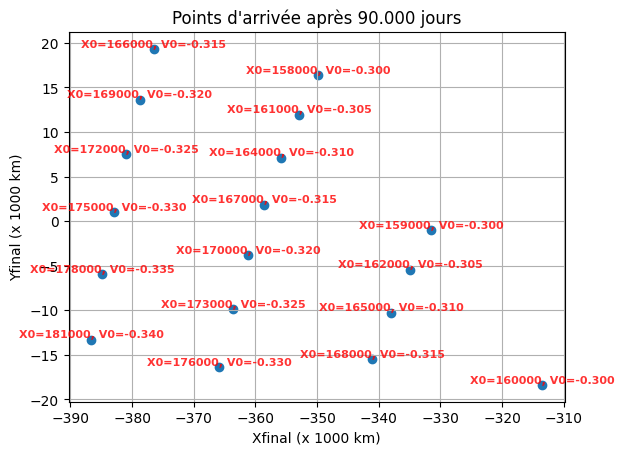

In [ ]:
Z=-470000
test_traj(Z=Z,Xmin=-400000.0,YN=20000.0,
    Xi=np.arange(150000,200000,1000),VYi=-np.arange(0.3,0.4,0.005),Papprox=180,Pas=1)

### Choix de **y0_init**, une des conditions initiales sélectionnées et tracé de la trajectoire avec la fonction **traj**

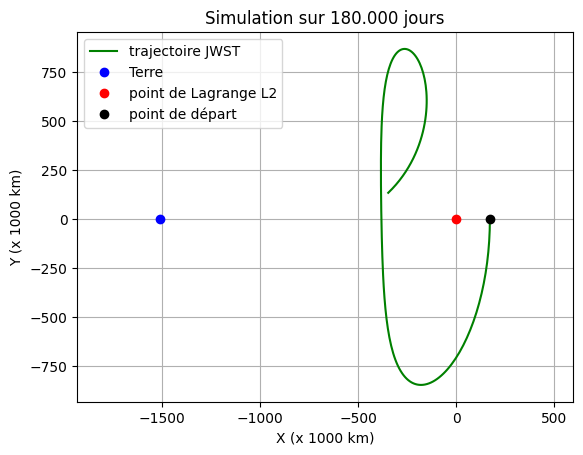

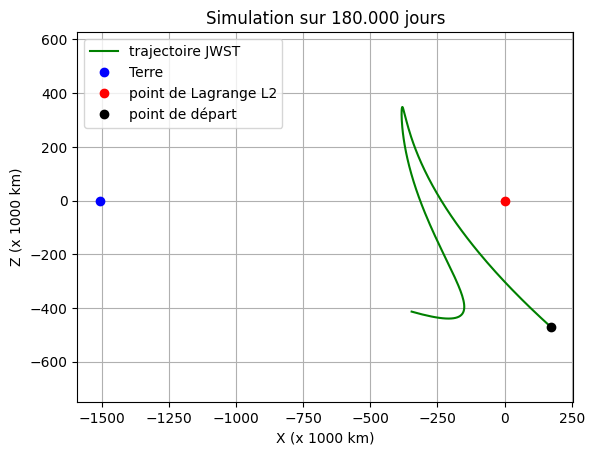

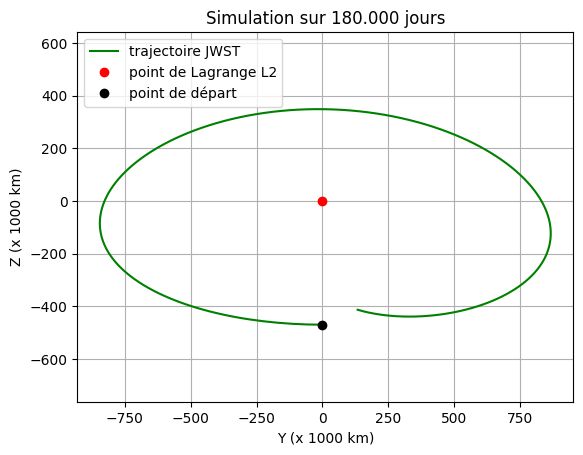

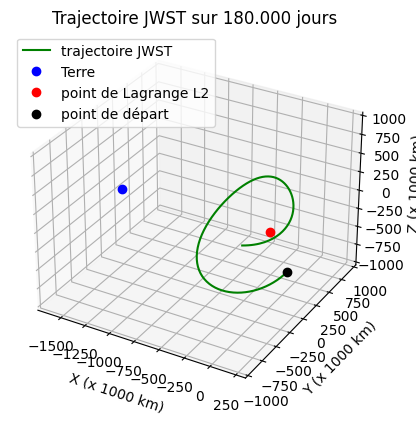

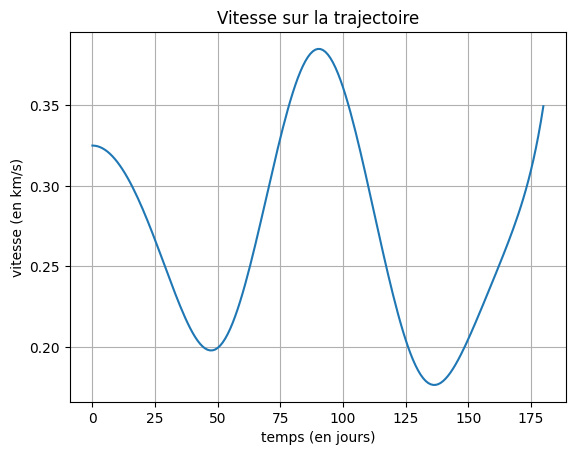

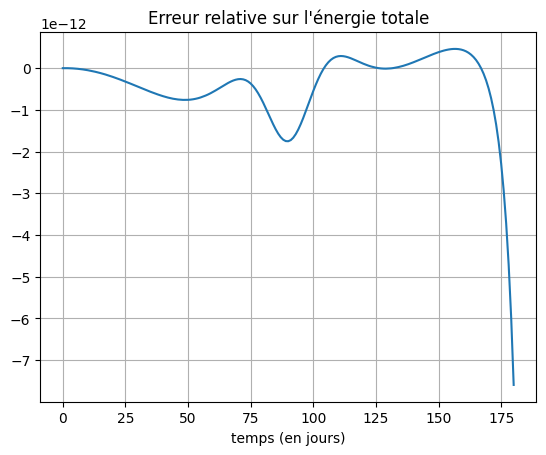

(-345940.39716889535, 133927.18332435485)

In [ ]:
# X0=175000;V0=-0.330;Z=-470000
X0=172000;V0=-0.325;Z=-470000
y0_init=[X0,0,Z,0,V0,0]
traj(y0=y0_init,Duree=180,Pas=1,Graph=True,Axe=False)

### Ajustement fin de **y0_init** vers **y0_peri** pour accéder à la trajectoire périodique avec la fonction **traj_opt**

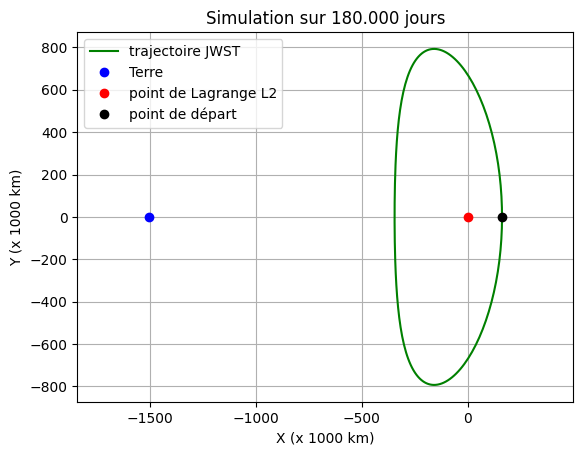

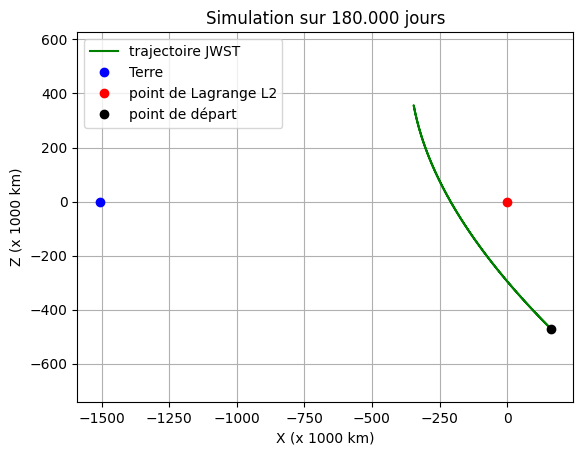

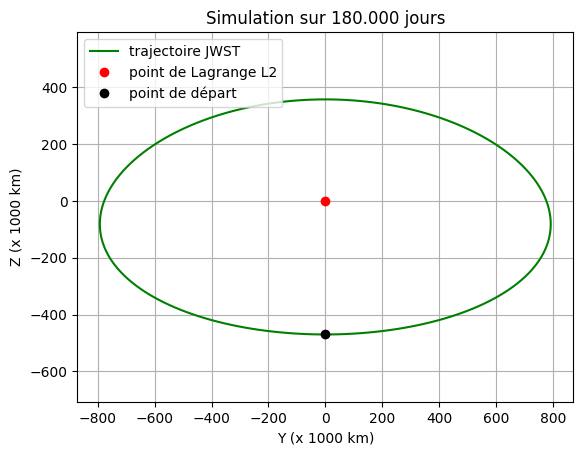

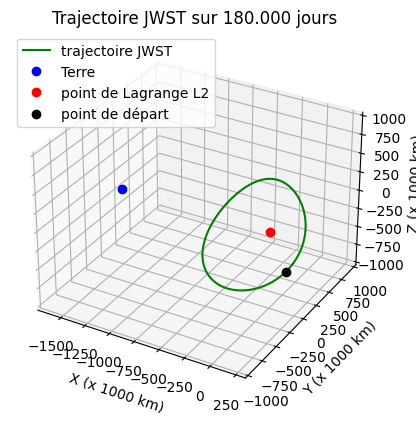

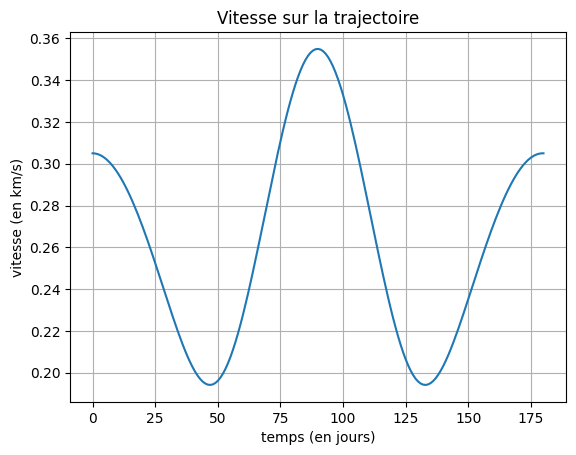

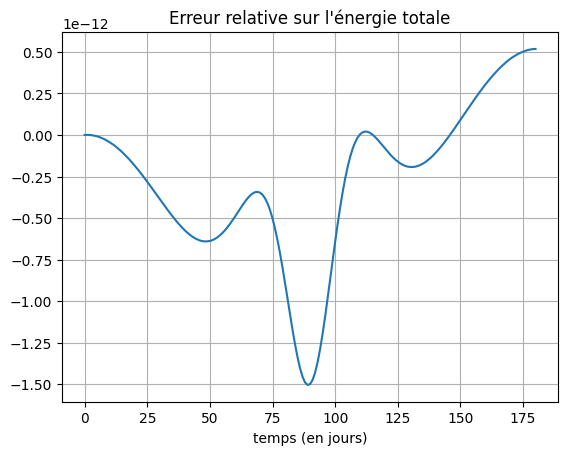

In [ ]:
y0_peri,y0_init,Periode=traj_opt(X0=X0,V0=V0,Z=Z,Papprox=180,Pas=1,Graph=True,Axe=False)

### Affichage de la condition initiale **y0_peri** donnant la trajectoire périodique, après ajustement de **y0_init**

In [ ]:
print('y0_peri =',y0_peri)
print('y0_init =',y0_init)
print('Periode =',Periode,' jours')

y0_peri = [161399.24168049282, 0, -470000, 0, -0.3050023264341407, 0]
y0_init = [172000, 0, -470000, 0, -0.325, 0]
Periode = 179.6723512612865  jours


### Simulation sur une durée plus longue pour mettre en évidence l'instabilité de la trajectoire

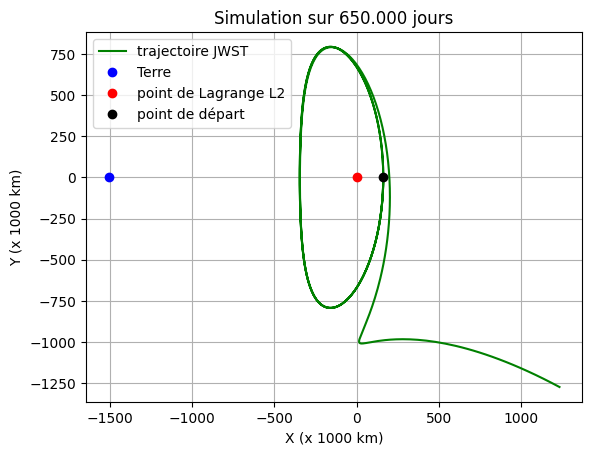

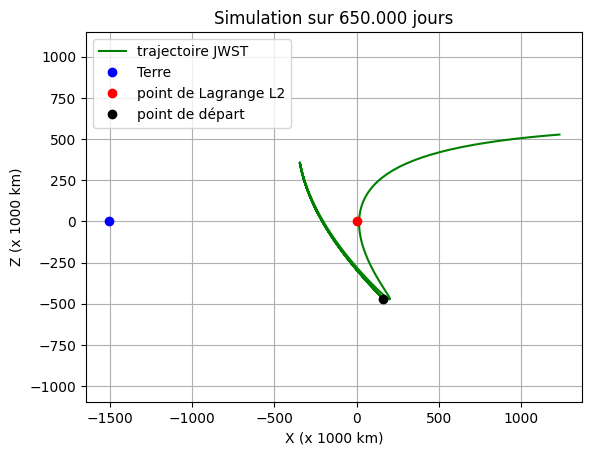

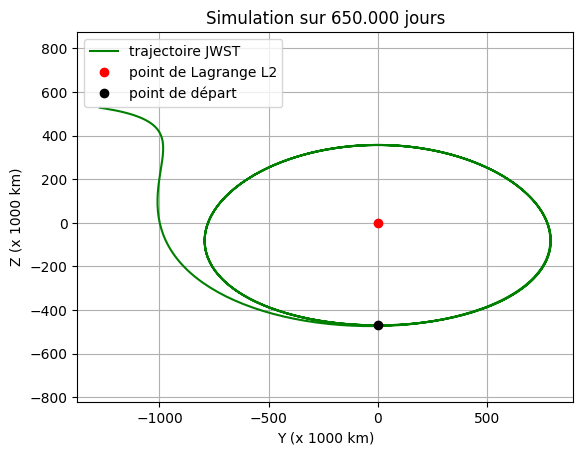

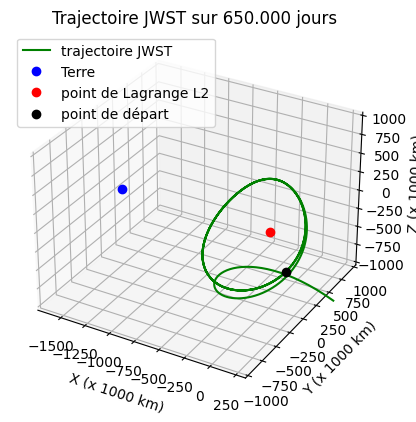

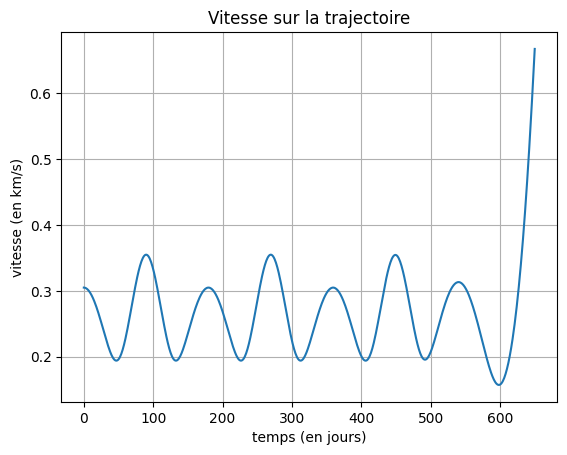

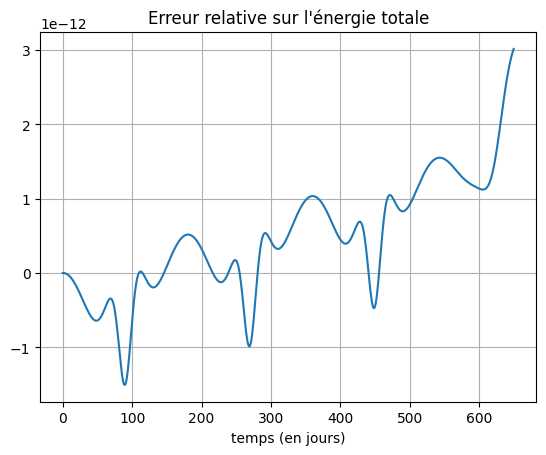

(1231691.346201935, -1273248.580619692)

In [ ]:
traj(y0=y0_peri,Duree=650,Pas=1,Graph=True,Axe=False)